**1.** Run the following cells to setup the environment

In [1]:
import requests, pandas as pd, json, copy
from IPython.display import JSON, Image
from requests.auth import HTTPBasicAuth

In [2]:
URL = 'http://mira.isi.edu:8000'
auth = HTTPBasicAuth('mint', 'm290sjafds8!')

**2.** Load a dataset that we want to model, and show the content of the dataset.

The dataset is supposed to be a [relational table](https://www.ibm.com/support/knowledgecenter/SSWU4L/Data/imc_Data/Data_q_a_watson_assistant/Relational_Tables371.html). If the data format is CSV, the first row is the header.

In [3]:
df = pd.read_csv('./examples/ethiopia_dashboard.csv', header=0)
df.head(5)

,Country Name,Year,"Population, total","Life expectancy at birth, total (years)","GNI per capita, Atlas method (current US$)",GDP (current US$),CO2 emissions (metric tons per capita)
0,Ethiopia,1960,22151278.0,38.419,NaN,NaN,0.015892
1,Ethiopia,1961,22671191.0,39.082,NaN,NaN,0.015042
2,Ethiopia,1962,23221389.0,39.711,NaN,NaN,0.017055
3,Ethiopia,1963,23798430.0,40.290,NaN,NaN,0.017720
4,Ethiopia,1964,24397022.0,40.810,NaN,NaN,0.016684


**3.** To send the table to the API for annotation, we need to convert the original table into a JSON format below:
```json
{
    "ontologies": ["http://wikiba.se/ontology#"],
    "source": [
        {"name": "<column name>", "values": ["<value of the column in first row>", "<value of the column in second row>", "..."]
    ]
}
```
and send it in the body of a `POST` request to `/v1.1/annotate`

In [4]:
payload = {
    "ontologies": ["http://datamart.isi.edu/ontology#"],
    "source": [
        {"name": "" if c.startswith("Unnamed:") else c, "values": df[c].tolist()}
        for c in df.columns
    ]
}
resp = requests.post(URL + "/v1.1/annotate", json=payload, auth=auth)
assert resp.status_code == 200

**4.** The JSON response that the server returns are in the following format:
```json
{
    "sms": [{
        "<ont_class_id>": {
            "iri": "<uri of the ontology class>",
            "properties": [
                ["<ontology predicate 1>", "<column_index>"], 
                ["<ontology predicate 2>", "<column_index>"]
            ],
            "links": [
                ["<ontology predicate 1>", "<ont_class_id>"]
            ]
        }
    }],
    "semantic_types": [
        [{
            "class": "<ontology class uri>",
            "predicate": "<ontology predicate uri>",
            "prob": "<probability of this semantic type (float)>"
        }]
    ],
    "prefixes": {
        "<prefix>": "<url>"
    }
}
```
where:
* `sms` is a list of predicted semantic models, sorted by the likelihood
* `semantic_types` is a list containing predicted semantic types for each column. In particular, an ith item in the list is predicted semantic types of the ith column in the data source.

In [5]:
JSON(resp.json(), indent=4)

<IPython.core.display.JSON object>

Run the following cell to draw the most probable semantic model

In [6]:
data = resp.json()
data = {
    "prefixes": data['prefixes'],
    "sm": data['sms'][0],
    "columns": df.columns.tolist()
}

In [7]:
resp2 = requests.post(URL + "/v1/draw", json=data, auth=auth, stream=all)
assert resp2.status_code == 200

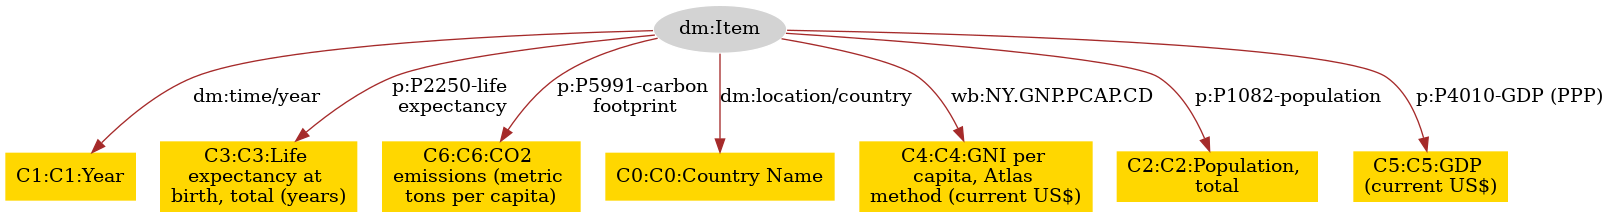

In [8]:
display(Image(resp2.content))